In [30]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from transformers import TFBertModel
from tensorflow.keras.layers import Conv2DTranspose, Reshape
from tensorflow.keras.layers import Conv2D, Flatten, LeakyReLU
from transformers import BertTokenizer
import numpy as np
import matplotlib.pyplot as plt

In [31]:
class TextEncoder(tf.keras.Model):
    def __init__(self, model_name='bert-base-uncased'):
        super(TextEncoder, self).__init__()
        self.bert = TFBertModel.from_pretrained(model_name)
        self.dense = Dense(512, activation='relu')

    def call(self, inputs):
        outputs = self.bert(inputs)[1]  # Get the pooled output
        x = self.dense(outputs)
        return x

In [32]:
class ImageGenerator(tf.keras.Model):
    def __init__(self):
        super(ImageGenerator, self).__init__()
        self.dense = Dense(8 * 8 * 128, activation='relu')
        self.reshape = Reshape((8, 8, 128))
        self.conv1 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')
        self.conv2 = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same')
        self.conv3 = Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same')
        self.conv4 = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same')

    def call(self, inputs):
        x = self.dense(inputs)
        x = self.reshape(x)
        x = tf.nn.relu(self.conv1(x))
        x = tf.nn.relu(self.conv2(x))
        x = tf.nn.relu(self.conv3(x))
        x = tf.nn.sigmoid(self.conv4(x))
        return x

In [33]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = Conv2D(64, (3, 3), strides=(2, 2), padding='same')
        self.conv2 = Conv2D(128, (3, 3), strides=(2, 2), padding='same')
        self.conv3 = Conv2D(256, (3, 3), strides=(2, 2), padding='same')
        self.conv4 = Conv2D(512, (3, 3), strides=(2, 2), padding='same')
        self.flatten = Flatten()
        self.fc = Dense(1)

    def call(self, inputs):
        x = LeakyReLU()(self.conv1(inputs))
        x = LeakyReLU()(self.conv2(x))
        x = LeakyReLU()(self.conv3(x))
        x = LeakyReLU()(self.conv4(x))
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [34]:
def generate_dummy_data(batch_size):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    texts = ["This is a sample text"] * batch_size
    text_inputs = tokenizer(texts, return_tensors="tf", padding=True, truncation=True, max_length=10)
    text_inputs = text_inputs['input_ids']
    real_images = np.random.rand(batch_size, 128, 128, 3).astype(np.float32)
    return text_inputs, real_images

In [35]:
@tf.function
def train_step(texts, real_images, text_encoder, image_generator, discriminator, gen_optimizer, disc_optimizer, loss_fn):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        text_embeddings = text_encoder(texts, training=True)
        generated_images = image_generator(text_embeddings, training=True)

        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = loss_fn(tf.ones_like(fake_output), fake_output)
        disc_loss = loss_fn(tf.ones_like(real_output), real_output) + \
                    loss_fn(tf.zeros_like(fake_output), fake_output)

    gradients_gen = gen_tape.gradient(gen_loss, image_generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gradients_gen, image_generator.trainable_variables))

    gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    disc_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [36]:
def train(num_epochs, batch_size, text_encoder, image_generator, discriminator, gen_optimizer, disc_optimizer, loss_fn):
    for epoch in range(num_epochs):
        texts, real_images = generate_dummy_data(batch_size)
        gen_loss, disc_loss = train_step(texts, real_images, text_encoder, image_generator, discriminator, gen_optimizer, disc_optimizer, loss_fn)


        print(f'Epoch {epoch}, Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}')
        sample_text = "example description"
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        sample_inputs = tokenizer([sample_text], return_tensors="tf", padding=True, truncation=True, max_length=10)
        sample_embedding = text_encoder(sample_inputs['input_ids'], training=False)
        generated_image = image_generator(sample_embedding, training=False)

In [37]:
def predict(text, text_encoder, image_generator):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    text_inputs = tokenizer([text], return_tensors="tf", padding=True, truncation=True, max_length=10)
    text_embedding = text_encoder(text_inputs['input_ids'], training=False)
    generated_image = image_generator(text_embedding, training=False)
    plt.imshow(generated_image[0].numpy())
    plt.axis('off')
    plt.show()


In [38]:
# Initialize models
text_encoder = TextEncoder()
image_generator = ImageGenerator()
discriminator = Discriminator()

# Initialize optimizers and loss function
gen_optimizer = tf.keras.optimizers.Adam(1e-4)
disc_optimizer = tf.keras.optimizers.Adam(1e-4)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Example training
num_epochs = 20
batch_size = 16
train(num_epochs, batch_size, text_encoder, image_generator, discriminator, gen_optimizer, disc_optimizer, loss_fn)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 0, Generator Loss: 0.6804300546646118, Discriminator Loss: 1.3928849697113037
Epoch 1, Generator Loss: 0.7019715905189514, Discriminator Loss: 1.3735038042068481
Epoch 2, Generator Loss: 0.7121894955635071, Discriminator Loss: 1.3607509136199951
Epoch 3, Generator Loss: 0.7165554761886597, Discriminator Loss: 1.3440532684326172
Epoch 4, Generator Loss: 0.7179034948348999, Discriminator Loss: 1.3351202011108398
Epoch 5, Generator Loss: 0.7196744084358215, Discriminator Loss: 1.3110804557800293
Epoch 6, Generator Loss: 0.7281805872917175, Discriminator Loss: 1.2970974445343018
Epoch 7, Generator Loss: 0.741569995880127, Discriminator Loss: 1.2757209539413452
Epoch 8, Generator Loss: 0.7539794445037842, Discriminator Loss: 1.2433760166168213
Epoch 9, Generator Loss: 0.7706812620162964, Discriminator Loss: 1.2136127948760986
Epoch 10, Generator Loss: 0.7971022129058838, Discriminator Loss: 1.1795432567596436
Epoch 11, Generator Loss: 0.8288173675537109, Discriminator Loss: 1.13098669

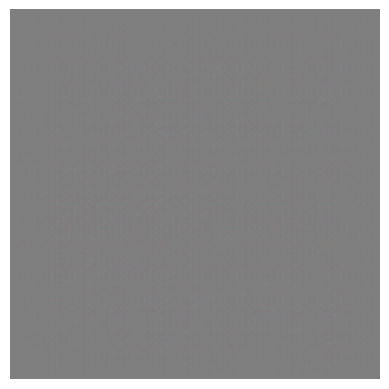

In [41]:
# Example prediction
example_text = "Wall."
predict(example_text, text_encoder, image_generator)